<a href="https://colab.research.google.com/github/li199959/one/blob/main/%E6%80%9D%E8%80%83.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

In [ ]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')


In [3]:
from google.colab import files

uploaded = files.upload()
log_sample = uploaded['BGL_2k.log'].decode().splitlines()


Saving BGL_2k.log to BGL_2k.log


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
inputs = {key: value.to(device) for key, value in inputs.items()}


In [4]:
inputs = tokenizer(log_sample, return_tensors="pt", padding=True, truncation=True, max_length=512)


In [7]:
input_ids_shape = inputs["input_ids"].shape
attention_mask_shape = inputs["attention_mask"].shape


In [8]:
input_ids_shape

torch.Size([2000, 285])

In [9]:
attention_mask_shape

torch.Size([2000, 285])

In [6]:
import torch

In [ ]:
with torch.no_grad():
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).numpy()


In [8]:
with torch.no_grad():
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()


OutOfMemoryError: ignored

In [10]:
import numpy as np


In [11]:
def batched_embeddings(model, tokenizer, logs, batch_size=32):
    # Split the logs into smaller batches
    batched_logs = [logs[i:i + batch_size] for i in range(0, len(logs), batch_size)]

    all_embeddings = []

    for batch in batched_logs:
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=512)
        inputs = {key: value.to(device) for key, value in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
            all_embeddings.append(embeddings)

    # Combine all batch embeddings
    return np.vstack(all_embeddings)

# Using the batched function to get embeddings
embeddings_batched = batched_embeddings(model, tokenizer, log_sample)

embeddings_batched.shape


(2000, 768)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.004s...
[t-SNE] Computed neighbors for 2000 samples in 0.372s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.577683
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.663620
[t-SNE] KL divergence after 300 iterations: 1.183493


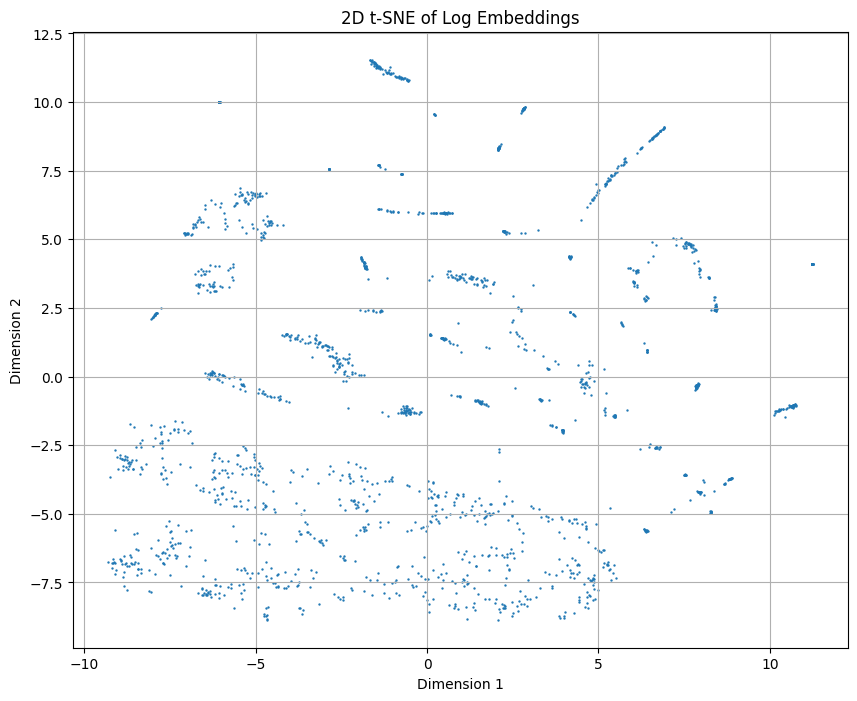

In [12]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Step 1: Use PCA to reduce dimensionality to 50 dimensions
pca = PCA(n_components=50)
pca_result = pca.fit_transform(embeddings_batched)

# Step 2: Use t-SNE to further reduce to 2 dimensions
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_result = tsne.fit_transform(pca_result)

# Step 3: Visualize the 2D t-SNE results
plt.figure(figsize=(10, 8))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], s=0.5)
plt.title('2D t-SNE of Log Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()


In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

# Number of clusters to be formed
num_clusters = 5

# Using KMeans for clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(embeddings_batched)
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

# Find the index of the log entry that is closest to each cluster center
closest_logs_indices, _ = pairwise_distances_argmin_min(cluster_centers, embeddings_batched)

# Extract the closest log entries
summary_logs = [log_sample[index] for index in closest_logs_indices]

summary_logs


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


['- 1123759596 2005.08.11 R35-M0-N6-C:J13-U01 2005-08-11-04.26.36.236761 R35-M0-N6-C:J13-U01 RAS KERNEL INFO CE sym 28, at 0x0fe65820, mask 0x04',
 'KERNDTLB 1118538836 2005.06.11 R30-M0-N9-C:J16-U01 2005-06-11-18.13.56.287869 R30-M0-N9-C:J16-U01 RAS KERNEL FATAL data TLB error interrupt',
 '- 1127243514 2005.09.20 NULL 2005-09-20-12.11.54.288690 NULL RAS MMCS ERROR idoproxydb hit ASSERT condition: ASSERT expression=0 Source file=idotransportmgr.cpp Source line=1043 Function=int IdoTransportMgr::SendPacket(IdoUdpMgr*, BglCtlPavTrace*)',
 '- 1120958403 2005.07.09 R21-M0-N3-C:J06-U11 2005-07-09-18.20.03.745197 R21-M0-N3-C:J06-U11 RAS KERNEL INFO generating core.10842',
 '- 1120145774 2005.06.30 R01-M1-NF-C:J05-U11 2005-06-30-08.36.14.017177 R01-M1-NF-C:J05-U11 RAS KERNEL INFO generating core.16483']

In [14]:
from sklearn.ensemble import IsolationForest

# Initialize and train the Isolation Forest model
iso_forest = IsolationForest(contamination=0.05, random_state=42)  # assuming 5% of the data might be anomalies
anomaly_scores = iso_forest.fit_predict(embeddings_batched)

# Identify the indices of anomalies
anomalies_indices = [index for index, score in enumerate(anomaly_scores) if score == -1]

# Extract the anomalous log entries
anomalous_logs = [log_sample[index] for index in anomalies_indices]

anomalous_logs[:10], len(anomalous_logs)  # Display the first 10 anomalous logs and the total number of anomalies detected


(['- 1118767283 2005.06.14 R20-M1-N3-C:J14-U01 2005-06-14-09.41.23.815131 R20-M1-N3-C:J14-U01 RAS KERNEL FATAL machine check: i-fetch......................0',
  '- 1118767320 2005.06.14 R25-M1-N9-C:J06-U11 2005-06-14-09.42.00.555171 R25-M1-N9-C:J06-U11 RAS KERNEL FATAL machine check: i-fetch......................0',
  '- 1118768357 2005.06.14 R25-M0-N3-C:J13-U11 2005-06-14-09.59.17.720736 R25-M0-N3-C:J13-U11 RAS KERNEL FATAL machine check: i-fetch......................0',
  '- 1118769993 2005.06.14 R20-M0-N4-C:J15-U01 2005-06-14-10.26.33.758477 R20-M0-N4-C:J15-U01 RAS KERNEL FATAL machine check: i-fetch......................0',
  '- 1118770603 2005.06.14 R24-M1-NE-C:J15-U11 2005-06-14-10.36.43.928442 R24-M1-NE-C:J15-U11 RAS KERNEL FATAL store operation.............................1',
  '- 1118770625 2005.06.14 R20-M0-NF-C:J07-U01 2005-06-14-10.37.05.332040 R20-M0-NF-C:J07-U01 RAS KERNEL FATAL store operation.............................1',
  '- 1118771075 2005.06.14 R24-M0-NF-C:J09-U01

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24120 (\N{CJK UNIFIED IDEOGRAPH-5E38}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25454 (\N{CJK UNIFIED IDEOGRAPH-636E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24322 (\N{CJK UNIFIED IDEOGRAPH-5F02}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


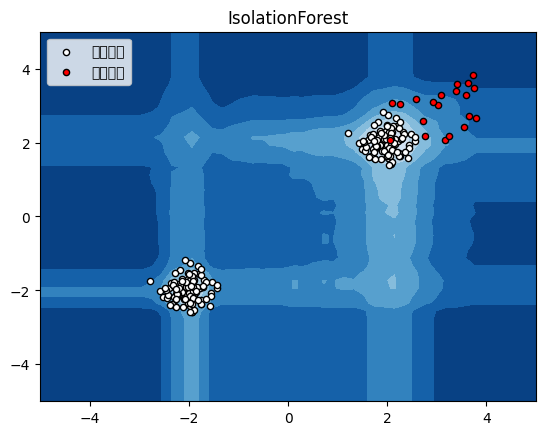

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# 生成数据
rng = np.random.RandomState(42)
X = 0.3 * rng.randn(100, 2)
X_train = np.r_[X + 2, X - 2]  # 正常数据
X_outliers = rng.uniform(low=2, high=4, size=(20, 2))  # 异常数据
X = np.r_[X_train, X_outliers]

# 孤立森林模型
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(X)
y_pred = clf.predict(X)

# 可视化
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("IsolationForest")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=20, edgecolor='k')
b2 = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red', s=20, edgecolor='k')

plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([b1, b2], ["正常数据", "异常数据"], loc="upper left")
plt.show()
